# SU: Assignment 5

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,f1_score,roc_auc_score, recall_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

In [55]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
df = wine_quality.data.original

In [56]:
df = pd.get_dummies(df, columns=['color'])
df = df.dropna()

In [57]:
df.head(10)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color_red,color_white
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1,0
5,7.4,0.66,0.00,1.8,0.075,13.0,40.0,0.9978,3.51,0.56,9.4,5,1,0
6,7.9,0.60,0.06,1.6,0.069,15.0,59.0,0.9964,3.30,0.46,9.4,5,1,0
7,7.3,0.65,0.00,1.2,0.065,15.0,21.0,0.9946,3.39,0.47,10.0,7,1,0
8,7.8,0.58,0.02,2.0,0.073,9.0,18.0,0.9968,3.36,0.57,9.5,7,1,0
9,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.9978,3.35,0.80,10.5,5,1,0


In [58]:
X = df.drop('quality',axis=1)
y = df['quality']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1112)

#### #We now have to decide where we will put the threhold for 'high quality' wine. Let's look at some stats

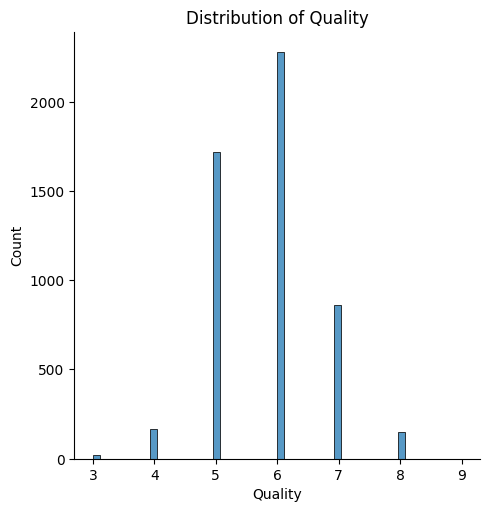

In [60]:
sns.displot(data=y_train, kde=False)
plt.title('Distribution of Quality')
plt.xlabel('Quality')
plt.ylabel('Count')
plt.show()

In [61]:
np.mean(y)

5.818377712790519

In [62]:
np.median(y)

6.0

#### We will say that >6 is 'high quality' wine (1), otherwise, low (0). After all, it makes sense that 'high quality' wine is rarer


In [63]:
df['quality'] = df['quality'].apply(lambda x: 1 if x>6 else 0)
X = df.drop('quality',axis=1)
y = df['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1112)

In [64]:
df['quality'].value_counts()

0    5220
1    1277
Name: quality, dtype: int64

In [76]:
#majority class
BASELINE_ACCURACY = 5220/(5220+1277)

### Sklearn Gradient Boosing

In [82]:
baseline_grad = GradientBoostingClassifier(n_estimators=100,learning_rate=0.1, random_state=1112)

In [83]:
baseline_grad.fit(X_train, y_train)

GradientBoostingClassifier(random_state=1112)

In [84]:
y_pred = baseline_grad.predict(X_test)

In [85]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [86]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8362
Precision: 0.6709
Recall: 0.3970
F1-score: 0.4988


#### Our (sklearn's) model is not very good. barely better than the baseline. We only correctly identified 40% of high quality wines. Can we do better?

### Custom Gradient Boosting Ensemble

In [253]:
class GradientForest:
    def __init__(self, n_estimators=100,learning_rate=0.1,estimator_depth=1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.estimator_depth = estimator_depth
        self.models = []
        self.intercept = None
        
    def fit(self, X, y):
        
        #Initialize with the mean for the first model
        self.intercept = np.mean(y)
        residuals = y - self.intercept  
        #Train n decision trees
        
        for _ in range(self.n_estimators):
            model = DecisionTreeRegressor(max_depth=self.estimator_depth)
            model.fit(X, residuals)
            
            current_prediction = self.learning_rate * model.predict(X)            
            #update residuals
            residuals -= current_prediction
            
            self.models.append(model)
    
    def predict(self, X):
        predictions = np.array([model.predict(X) for model in self.models])
        bound = (np.sum(predictions, axis=0)+self.intercept).astype(int)
        return np.where(bound >= 0,1,0)

In [303]:
my_grad = GradientForest(n_estimators=100, learning_rate=0.001,estimator_depth=1) 

In [308]:
my_grad.fit(X_train, y_train)
y_pred = my_grad.predict(X_test)

In [309]:
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

In [310]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7254
Precision: 0.4078
Recall: 0.7453
F1-score: 0.5272


In [311]:
y_pred

array([0, 0, 1, ..., 1, 1, 0])

#### Eh, not really, but at least the recall is better

We used a lower learning rate, which gave as sligtly better accuracy results. But it is still worse than the majority class baseline. Using too much (>1000) or to few (<100) estimators, our model performs worse.

In [314]:
y_pred_train = my_grad.predict(X_train)

In [315]:
accuracy = accuracy_score(y_train, y_pred_train)
f1 = f1_score(y_train, y_pred_train)
precision = precision_score(y_train, y_pred_train)
recall = recall_score(y_train, y_pred_train)

In [316]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.7235
Precision: 0.3840
Recall: 0.7000
F1-score: 0.4960


#### Based on these results, we can conclude that our model doesn't overfit. It just sucks

# XGBoost, LightCBM, CatBoost

In [319]:
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.datasets import make_classification

#### XGBoost

In [322]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Predict on train set
y_pred_train_xgb = xgb_model.predict(X_train)

# Calculate metrics
accuracy_xgb = accuracy_score(y_train, y_pred_train_xgb)
precision_xgb = precision_score(y_train, y_pred_train_xgb)
recall_xgb = recall_score(y_train, y_pred_train_xgb)
f1_xgb = f1_score(y_train, y_pred_train_xgb)

# Print metrics
print("XGBoost Metrics:")
print(f"Accuracy: {accuracy_xgb:.4f}")
print(f"Precision: {precision_xgb:.4f}")
print(f"Recall: {recall_xgb:.4f}")
print(f"F1-score: {f1_xgb:.4f}")

[13:19:48] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost Metrics:
Accuracy: 0.9973
Precision: 0.9980
Recall: 0.9881
F1-score: 0.9930


/home/jon/.local/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


#### CatBoost

In [326]:
# Create and train CatBoost classifier
catboost_model = CatBoostClassifier(verbose=0)
catboost_model.fit(X_train, y_train)

# Predict on train set
y_pred_train_catboost = catboost_model.predict(X_train)

# Calculate metrics
accuracy_catboost = accuracy_score(y_train, y_pred_train_catboost)
precision_catboost = precision_score(y_train, y_pred_train_catboost)
recall_catboost = recall_score(y_train, y_pred_train_catboost)
f1_catboost = f1_score(y_train, y_pred_train_catboost)

# Print metrics
print("CatBoost Metrics:")
print(f"Accuracy: {accuracy_catboost:.4f}")
print(f"Precision: {precision_catboost:.4f}")
print(f"Recall: {recall_catboost:.4f}")
print(f"F1-score: {f1_catboost:.4f}")

CatBoost Metrics:
Accuracy: 0.9511
Precision: 0.9667
Recall: 0.7752
F1-score: 0.8604


#### LGBM

In [324]:
# Create and train LightGBM classifier
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train)

# Predict on train set
y_pred_train_lgbm = lgbm_model.predict(X_train)

# Calculate metrics
accuracy_lgbm = accuracy_score(y_train, y_pred_train_lgbm)
precision_lgbm = precision_score(y_train, y_pred_train_lgbm)
recall_lgbm = recall_score(y_train, y_pred_train_lgbm)
f1_lgbm = f1_score(y_train, y_pred_train_lgbm)

# Print metrics
print("LightGBM Metrics:")
print(f"Accuracy: {accuracy_lgbm:.4f}")
print(f"Precision: {precision_lgbm:.4f}")
print(f"Recall: {recall_lgbm:.4f}")
print(f"F1-score: {f1_lgbm:.4f}")

LightGBM Metrics:
Accuracy: 0.9727
Precision: 0.9728
Recall: 0.8842
F1-score: 0.9263


#### They are clearly much better, why even try :/